In [1]:
from random import random
import numpy as np
from numpy import array
from numpy import cumsum
import matplotlib.pyplot as plt
import tensorflow as tf
import sys
from keras import regularizers
from keras.models import Sequential
from keras.models import Model
from keras.layers import LSTM
from keras.layers import Dense, Permute, Conv1D, Activation, GlobalAveragePooling1D, concatenate
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Input
from keras.layers import Dropout
from keras.layers import Masking
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.layers.normalization import BatchNormalization
import MulensModel as mu


# create a sequence classification instance
def get_lightcurve(n_timesteps):
    # create a sequence of random numbers in [0,1] and their random errors
    X = array([array([random(),random()/10]) for _ in range(n_timesteps)])
    y = 0
    #0.1 chance of 'lightcurve' being 'lensed' (gaussian magnification on top)
    if (random() < 0.3):
        sigma = n_timesteps*random()/400 + n_timesteps/5000
        a = random()*3 + 0.4
        b = random()
        lens = a * np.exp(-(np.linspace(0,1,n_timesteps) - b)**2 / (2 * sigma**2)) + 1.0
        X[:,0] *= lens
        y = 1
    X[:,0] = (X[:,0] - np.min(X[:,0])) / (np.max(X[:,0]) - np.min(X[:,0]))
    X[:,1] = (X[:,1] - np.min(X[:,1])) / (np.max(X[:,1]) - np.min(X[:,1]))
    
    
    # determine the class outcome for each item in cumulative sequence
    #y = array([0 if x < limit else 1 for x in cumsum(X)])
    # reshape input and output data to be suitable for LSTMs
    X = X.reshape(1, n_timesteps, 2)
    #y = y.reshape(1, n_timesteps, 2)
    y = array([[y]])
    return X, y
 


Using TensorFlow backend.


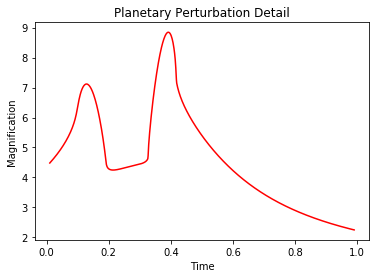

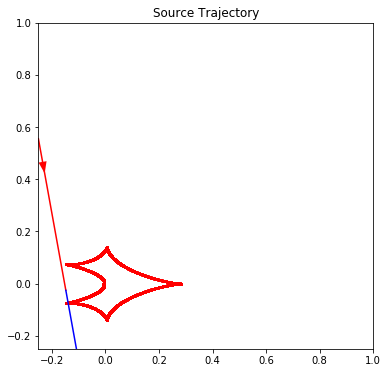

In [163]:
# Create a PSPL model
t_0 = 0.3
u_0 = -0.15
t_E = 1.5

#pspl = Model({'t_0': t_0, 'u_0': u_0, 't_E': t_E})

# Create a planet model with same PSPL parameters
s = 1.0
q = 0.01
alpha = 280.0
rho = 0.03

planet = mu.model.Model(
    {'t_0': t_0, 'u_0': u_0, 't_E': t_E, 's': s, 'q': q, 'alpha': alpha,
     'rho': rho})
planet.set_magnification_methods([0., 'VBBL', 1.])

# Plot detail of the planet perturbation
plt.figure()
planet.plot_magnification(
    t_range=[0.01, 0.99], color='red', linestyle='-', zorder=2, label='Planet')
plt.title('Planetary Perturbation Detail')

# Plot source trajectory and caustic
plt.figure(figsize=(6, 6))
planet.plot_trajectory(t_range=[t_0 - t_E, t_0], caustics=True, color='red')
planet.plot_trajectory(t_range=[t_0, t_0 + t_E], caustics=True, color='blue')
plt.xlim(-0.25, 1.0)
plt.ylim(-0.25, 1.0)
plt.title('Source Trajectory')

plt.show()

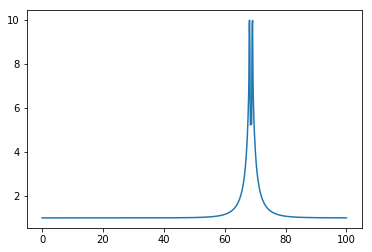

In [124]:
plt.plot(np.linspace(0,100,1000),planet.magnification(np.linspace(3580.95,3597.05,1000)))

In [116]:
planet.magnification([3589.01,3594.99])

array([1.00006111, 1.00006111])

In [3]:
def create_lens(length):
    # Create a PSPL model
    t_0 = random()*0.7 + 0.15 #0.25-0.75
    u_0 = -random()*0.16 - 0.06 # -0.06 -> - 0.22 shape
    t_E = (random()*0.9 + 0.8) / (length/163) #min should be about 0.7, max 1.8 width, normalise for length

    # Create a binary lens model with same PSPL parameters
    s = 1.0
    q = 0.01
    alpha = np.random.normal(270.,1.5)#260 - 280
    rho = np.random.normal(0.021,0.003) #0.01 - 0.04

    lens = mu.model.Model(
        {'t_0': t_0, 'u_0': u_0, 't_E': t_E, 's': s, 'q': q, 'alpha': alpha,
         'rho': rho})
    lens.set_magnification_methods([0., 'VBBL', 1.])  
    
    return lens.magnification(np.linspace(0.001,0.999,length))
    
def normalize_data(lightcurve):
    lightcurve[:,0] = (lightcurve[:,0] - np.min(lightcurve[:,0])) / (np.max(lightcurve[:,0]) - np.min(lightcurve[:,0]))
    lightcurve[:,1] = (lightcurve[:,1] - np.min(lightcurve[:,1])) / (np.max(lightcurve[:,1]) - np.min(lightcurve[:,1]))
    return lightcurve

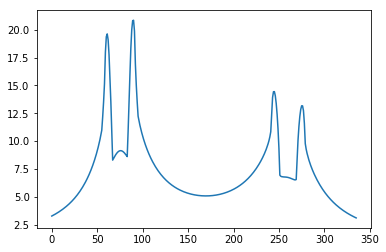

In [892]:
plt.plot(create_lens(336)*create_lens(336))

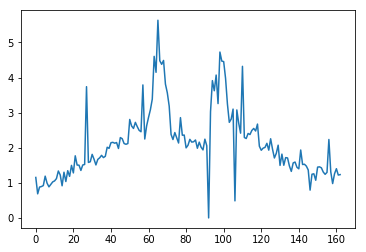

In [855]:
plt.plot(training_data[95,:,0]*create_lens(163))

In [4]:
N_DATA = 98000
SHORTEST = 163
LONGEST = 336

In [893]:

#Get Real simulated lightcurves for training, validation and test 
import csv
training_data = np.zeros((N_DATA,LONGEST,2))
training_labels = np.zeros(N_DATA)
for i in range(N_DATA):
    reader = csv.reader(open("simulated_lightcurves_10/simulated_lightcurve_"+ str(i) + ".csv", "r"), delimiter=",")
    x = list(reader)
    x.pop(0)
    lightcurve = np.array(x)[:,1:].astype("float")
    #prepad with zeros
    pad = np.zeros((LONGEST-len(x),2))
    lightcurve = np.concatenate((pad,lightcurve))
    if (random()<0.45): #lens it
        if (len(x)>300 and random()<0.7):
            lens = create_lens(LONGEST)*create_lens(LONGEST) #two events on one light curve 
        else:
            lens = create_lens(LONGEST)
        lightcurve[:,0] *= lens
        training_labels[i] = 1
        
    lightcurve = normalize_data(lightcurve)
    
    training_data[i,:,:] = lightcurve


In [894]:
#make validation set
import csv
val_data = np.zeros((2000,LONGEST,2))
val_labels = np.zeros(2000)
for i in range(2000):
    reader = csv.reader(open("simulated_lightcurves_10/simulated_lightcurve_"+ str(N_DATA+i) + ".csv", "r"), delimiter=",")
    x = list(reader)
    x.pop(0)
    lightcurve = np.array(x)[:,1:].astype("float")
    
    #prepad with zeros
    pad = np.zeros((LONGEST-len(x),2))
    lightcurve = np.concatenate((pad,lightcurve))
    
    if (random()<0.35): #lens it
        if (len(x)>280 and random()<0.8):
            lens = create_lens(LONGEST)*create_lens(LONGEST) #two events on one light curve 
        else:
            lens = create_lens(LONGEST)
        lightcurve[:,0] *= lens
        val_labels[i] = 1
        
    lightcurve = normalize_data(lightcurve)
    
    val_data[i,:,:] = lightcurve

In [ ]:
#Make fake training, validation and test sets to mimic real blazar data
#training
data = np.random.rand(1000,250,2)
labels = np.zeros(1000)
data[:,:,1] *= 0.15 * random() #errors

for i in range(1000):
    if (random() < 0.4):
        sigma = 250*random()/400 + 250/5000
        a = random()*4 + 0.4
        b = random()
        lens = a * np.exp(-(np.linspace(0,1,250) - b)**2 / (2 * sigma**2)) + 1.0
        data[i,:,0] *= lens
        labels[i] = 1
    data[i,:,0] = (data[i,:,0] - np.min(data[i,:,0])) / (np.max(data[i,:,0]) - np.min(data[i,:,0])) #max-min normalization
    data[i,:,1] = (data[i,:,1] - np.min(data[i,:,1])) / (np.max(data[i,:,1]) - np.min(data[i,:,1]))
    
data = data.astype("float32") #for tensorflow compatibility

#evaluation/test set
data_val = np.random.rand(1000,250,2)
labels_val = np.zeros(1000)
data_val[:,:,1] *= 0.15 * random() #errors

for i in range(100):
    if (random() < 0.3):
        sigma = 250*random()/400 + 250/5000
        a = random()*3 + 0.4
        b = random()
        lens = a * np.exp(-(np.linspace(0,1,250) - b)**2 / (2 * sigma**2)) + 1.0
        data_val[i,:,0] *= lens
        labels_val[i] = 1
    data_val[i,:,0] = (data_val[i,:,0] - np.min(data_val[i,:,0])) / (np.max(data_val[i,:,0]) - np.min(data_val[i,:,0])) #max-min normalization
    data_val[i,:,1] = (data_val[i,:,1] - np.min(data_val[i,:,1])) / (np.max(data_val[i,:,1]) - np.min(data_val[i,:,1]))
    
data_val = data_val.astype("float32") #for tensorflow compatibility


In [895]:
#Turn fake training data in TFrecords file
# Helperfunctions to make your feature definition more readable
training_data = training_data.astype("float32") #for tensorflow compatibility

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value): #requires ints I think, so have to convert double data to int form
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

# create filewriter
writer = tf.python_io.TFRecordWriter("Training_data")

#save training set
for i in range(N_DATA):
    # Define the features of your tfrecord
    feature = {'lightcurve':  _bytes_feature(tf.compat.as_bytes(training_data[i,:,:].tostring())),
               'label':  _int64_feature(training_labels[i].astype("int64"))}
    
    # Serialize to string and write to file
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    writer.write(example.SerializeToString())
    
writer.close()
sys.stdout.flush()

In [896]:
#save val set
val_data = val_data.astype("float32")

# create filewriter
writer = tf.python_io.TFRecordWriter("Validation_data")

#save training set
for i in range(2000):
    # Define the features of your tfrecord
    feature = {'lightcurve':  _bytes_feature(tf.compat.as_bytes(val_data[i,:,:].tostring())),
               'label':  _int64_feature(val_labels[i].astype("int64"))}
    
    # Serialize to string and write to file
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    writer.write(example.SerializeToString())
    
writer.close()
sys.stdout.flush()

In [5]:
BATCH_SIZE = 32

def _parse_function(proto):
    # define your tfrecord again. Remember that you saved your image as a string.
    keys_to_features = {'lightcurve': tf.FixedLenFeature([], tf.string),
                        "label": tf.FixedLenFeature([], tf.int64)}
    
    # Load one example
    parsed_features = tf.parse_single_example(proto, keys_to_features)
    
    # Turn your saved image string into an array
    parsed_features['lightcurve'] = tf.decode_raw(
        parsed_features['lightcurve'], tf.float32)
    
    return parsed_features['lightcurve'], parsed_features["label"]

  
def create_dataset(filepath):
    
    # This works with arrays as well
    dataset = tf.data.TFRecordDataset(filepath)
    
    # Maps the parser on every filepath in the array. You can set the number of parallel loaders here
    dataset = dataset.map(_parse_function, num_parallel_calls=8)
    
    # Set the number of datapoints you want to load and shuffle, buffer size controls how random shuffling is
    dataset = dataset.shuffle(1000)
    
    # Set the batchsize
    dataset = dataset.batch(BATCH_SIZE)
    
    # This dataset will go on forever
    dataset = dataset.repeat()
    
    # Create an iterator
    iterator = dataset.make_one_shot_iterator()
    
    # Create your tf representation of the iterator
    lightcurve, label = iterator.get_next()

    # Bring your picture back in shape
    lightcurve = tf.reshape(lightcurve, [-1, LONGEST, 2])
    label = tf.reshape(label, [-1, 1])
    label = tf.cast(label,tf.float32)
    
    # Create a one hot array for your labels
    #label = tf.one_hot(label, NUM_CLASSES)
    
    return lightcurve, label

In [6]:
# define problem properties
STEPS_PER_EPOCH= int((N_DATA - 2000)/ BATCH_SIZE)
N_EPOCHS = 10
History = []

#Get datatensors
lightcurve, label = create_dataset("Training_data")
val_lightcurve, val_label = create_dataset("Validation_data")

In [7]:
def generate_model_2(data="Training_data"):
    #Get datatensors
    lightcurve, label = create_dataset(data)
    
    ip = Input(tensor=lightcurve)
    x = Masking(mask_value=0., input_shape=(LONGEST, 2))(ip)

    x = Bidirectional(LSTM(8, return_sequences=False))(x)
    x = Dropout(0.8)(x)

    #y = Permute((2, 1))(ip)
    y = Conv1D(128, 8, padding='same', kernel_initializer='he_uniform')(ip)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = Conv1D(256, 5, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = Conv1D(128, 3, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = GlobalAveragePooling1D()(y)

    x = concatenate([x, y])

    #x = Dense(72, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01))(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(ip, out)
    model.summary()

    # add load model code here to fine-tune

    return model

In [8]:
def generate_model_1(data="Training_data"):
    #Get datatensors
    lightcurve, label = create_dataset(data)
    model_input = Input(tensor=lightcurve)
    model_output = Masking(mask_value=0., input_shape=(LONGEST, 2))(model_input)
    model_output = Bidirectional(LSTM(24, return_sequences=False, dropout=0.4, recurrent_dropout=0.2, 
                                      kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)), 
                                         input_shape=(LONGEST, 2))(model_output)
    model_output = Dense(12, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01))(model_output)
    model_output = BatchNormalization()(model_output)
    model_output = Dropout(0.5)(model_output)
    model_output = Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01))(model_output)
    
    model = Model(inputs=model_input, outputs=model_output)
    model.summary()
    
    return model
    
    

In [9]:
#set callbacks
model_checkpoint = ModelCheckpoint("model_weightsBLSTM", verbose=1,
                                       monitor='val_acc', save_best_only=True, save_weights_only=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', patience=5, mode='auto',
                                  factor=1/np.sqrt(2), cooldown=5, min_lr=1e-4, verbose=2)
callback_list = [model_checkpoint, reduce_lr]

#compile model
train_model = generate_model_2()
train_model.compile(loss='binary_crossentropy', optimizer='adam', 
                    metrics=['acc'], target_tensors=label)

####################### val_model
# val_model_input = Input(tensor=val_lightcurve)
# #val_model_output = Masking(mask_value=0., input_shape=(LONGEST, 2))(val_model_input)
# val_model_output = train_model(val_model_output)
# val_model = Model(inputs=val_model_input,outputs=val_model_output)
# val_model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['acc'],target_tensors=val_label)

################# test model
test_model_input = Input(shape=(None,2))
test_model_output = train_model(test_model_input)
test_model = Model(inputs=test_model_input, outputs=test_model_output)
test_model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['acc'])

################## train
his = train_model.fit(epochs=N_EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, validation_steps=int(2000/BATCH_SIZE), callbacks=callback_list)
History.append(his)
# Train_loss.append(his.history['loss'][0])
# Train_acc.append(his.history['acc'][0])
    
#     loss, acc = val_model.evaluate(steps=int(1000/BATCH_SIZE))
#     print("val_loss: ",loss, " val_acc: ", acc)
#     Val_loss.append(loss)
#     Val_acc.append(acc)
    
# plt.plot(Val_acc, label="val_acc")
# plt.plot(Val_loss, label="val_loss")
# plt.plot(Train_acc, label="train_acc")
# plt.plot(Train_loss, label="train_loss")
# plt.legend()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 336, 2)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 336, 128)     2176        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 336, 128)     512         conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 336, 128)     0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv1d_2 (

KeyboardInterrupt: 

In [964]:
train_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_63 (InputLayer)        (None, 336, 2)            0         
_________________________________________________________________
masking_3 (Masking)          (None, 336, 2)            0         
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 48)                5184      
_________________________________________________________________
dense_35 (Dense)             (None, 12)                588       
_________________________________________________________________
batch_normalization_6 (Batch (None, 12)                48        
_________________________________________________________________
dropout_6 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 13        
Total para

In [904]:
loss, acc = val_model.evaluate(steps=int(2000/BATCH_SIZE))
print(loss,acc)

62/62 [==============================] - 6s 104ms/step
0.4762929437621947 0.8256048387096774


In [905]:
ypred = np.round(test_model.predict(val_data[0:2000,:,:],steps=1))

In [907]:
wrong=[]
for i,y in enumerate(ypred):
    if y != val_labels[i]:
        wrong.append(i)
print(len(wrong))

345


In [962]:
test_model.predict(np.expand_dims(val_data[wrong[200],:,:],axis=0),steps=1)

array([[0.78415984]], dtype=float32)

0.0


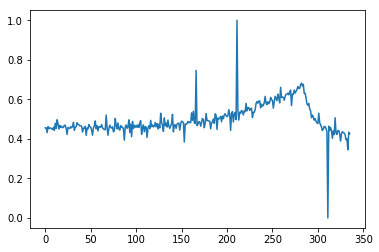

In [961]:
plt.plot(val_data[wrong[210],:,0])
print(val_labels[wrong[210]])

In [908]:
import sklearn.metrics
import itertools
confm = sklearn.metrics.confusion_matrix(val_labels, ypred)

In [909]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[977 323]
 [ 22 678]]


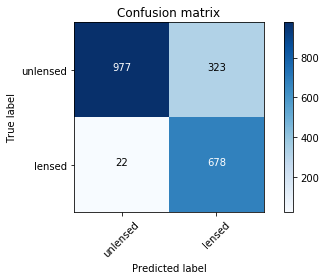

In [910]:
plot_confusion_matrix(confm, classes=['unlensed','lensed'])

In [925]:
reader = csv.reader(open("J1415+1320.csv", "r"), delimiter=",")
x = list(reader)
x.pop(0)
test_lightcurve = np.array(x)[:LONGEST,1:].astype("float")
test_lightcurve = normalize_data(test_lightcurve)
test_model.predict(np.expand_dims(test_lightcurve,axis=0),steps=1)

array([[0.74174756]], dtype=float32)

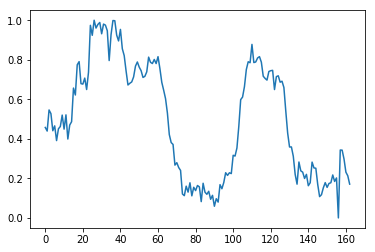

In [613]:
plt.plot(test_lightcurve[:,0])